In [26]:
import iCLIP
import CGAT.GTF as GTF
from functools import partial
import CGAT.IOTools as IOTools
import pandas
import CGAT.Intervals as Intervals

In [32]:
def flank5_meta(transcript, length):
    
    exons = [e for e in transcript if e.feature=="exon"]
    
    if exons[0].strand == "-":
        start = max(x.end for x in exons)
        end = start + length
    else: 
        end = min(x.start for x in exons)
        start = end - length
        
    returned_exon = GTF.Entry().fromGTF(exons[0])
    returned_exon.start = start
    returned_exon.end = end
    
    return [returned_exon]
    
    
    

In [33]:
def flank3_meta(transcript, length):
    
    exons = [e for e in transcript if e.feature=="exon"]
    
    if exons[0].strand == "+":
        start = max(x.end for x in exons)
        end = start + length
    else: 
        end = min(x.start for x in exons)
        start = end - length
        
    returned_exon = GTF.Entry().fromGTF(exons[0])
    returned_exon.start = start
    returned_exon.end = end
    
    return [returned_exon]

In [77]:
def CDS_meta(transcript):
    
    CDS = [e for e in transcript if e.feature=="CDS"]
    
    returned_exons = [GTF.Entry().fromGTF(e) for e in CDS]
    for e in returned_exons:
        e.feature = "exon"
        
    return returned_exons

def UTR3_meta(transcript):
    
    exons = GTF.asRanges(transcript, "exon")
    cds = GTF.asRanges(transcript, "CDS")

    utrs = Intervals.truncate(exons,cds)

    if transcript[0].strand == "+":
        utr3 = [exon for exon in utrs
                    if exon[0] >= cds[-1][1]]
    else:
        utr3 = [exon for exon in utrs
                if exon[-1] <= cds[0][0]]

    for e in transcript:
        if e.feature == "exon":
            template_exon = e
            break
            
    returned_exons = []     
    for e in utr3:
        gtf = GTF.Entry().fromGTF(template_exon)
        gtf.start = e[0]
        gtf.end = e[1]
        returned_exons.append(gtf)
        
    return returned_exons


def UTR5_meta(transcript):
    
    exons = GTF.asRanges(transcript, "exon")
    cds = GTF.asRanges(transcript, "CDS")

    utrs = Intervals.truncate(exons,cds)

    if transcript[0].strand == "-":
        utr3 = [exon for exon in utrs
                    if exon[0] >= cds[-1][1]]
    else:
        utr3 = [exon for exon in utrs
                if exon[-1] <= cds[0][0]]

    for e in transcript:
        if e.feature == "exon":
            template_exon = e
            break
            
    returned_exons = []     
    for e in utr3:
        gtf = GTF.Entry().fromGTF(template_exon)
        gtf.start = e[0]
        gtf.end = e[1]
        returned_exons.append(gtf)
        
    return returned_exons

In [97]:
def intron_meta(transcript):
    
    introns = GTF.toIntronIntervals(transcript)
    
    for e in transcript:
        if e.feature == "exon":
            template_exon = e
            break
            
    returned_exons = []     
    for e in introns:
        gtf = GTF.Entry().fromGTF(template_exon)
        gtf.start = e[0]
        gtf.end = e[1]
        returned_exons.append(gtf)
        
    return returned_exons
    

In [90]:
def transcript_meta(transcript, getter, regions, names, bins, length_norm=True):
    
    region_exons = [region_fun(transcript) for region_fun in regions]
    
    region_lengths = [sum(x.end - x.start for x in r) for r in region_exons]
    region_exons = [r for r,l in zip(region_exons, region_lengths) if l >0]
    region_lengths = [l for l in region_lengths if l>0]
    bins = [b for b,l in zip(bins, region_lengths) if l>0]
    names = [n for n,l in zip(names, region_lengths) if l>0]
    
    region_counts = [iCLIP.count_transcript(t, getter) for t in region_exons]
    region_binned_counts = [iCLIP.meta.bin_counts(c,l,b) for c,l,b in
                                zip(region_counts, region_lengths, bins)]
    if length_norm:
        region_binned_counts = [x*b/l for x,l,b in zip(region_binned_counts, 
                                                   region_lengths,
                                                   bins)]
    profile = pandas.concat(region_binned_counts, keys=names,
                            names=["region", "region_bin"])
    return profile
    

In [114]:
regions = [partial(flank5_meta, length=500), UTR5_meta, CDS_meta,  UTR3_meta, partial(flank3_meta, length=500)]
names = ["5' Flank", "5' UTR", "CDS",  "3' UTR", "3' Flank"]
bins = [50,20,100, 70,50]
index = [(n, 0) for n in names]
profile = pandas.Series(index=pandas.MultiIndex.from_tuples(index, names = ["region", "region_bin"]))
getter = iCLIP.make_getter(bedfile = "/ifs/projects/proj028/TREX_iCLIP_3reps/deduped.dir/Alyref-FLAG-union.bed.gz")
for transcript in GTF.transcript_iterator(
    GTF.iterator(
        IOTools.openFile(
            "/ifs/projects/proj028/project_pipeline_iCLIP5/expressed_transcripts.gtf.gz"))):
        
    if transcript[0].contig != "chr1":
        continue
        
    if transcript[0].source != "protein_coding":
        continue
    
    this_profile = transcript_meta(transcript, getter, regions, names, bins)
    this_profile = this_profile/this_profile.sum()
    
    profile = profile.add(this_profile, fill_value=0)
        
    
    

In [115]:
profile.name = "density"
flat_profile = profile.reindex(names, level="region").reset_index()

In [113]:
flat_profile

,region,region_bin,density
0,5' Flank,0,1.589980
1,5' Flank,1,1.022967
2,5' Flank,2,2.353543
3,5' Flank,3,2.137927
4,5' Flank,4,3.082851
5,5' Flank,5,2.628516
6,5' Flank,6,1.683160
7,5' Flank,7,1.929785
8,5' Flank,8,1.869209
9,5' Flank,9,1.473554


In [86]:
%matplotlib inline

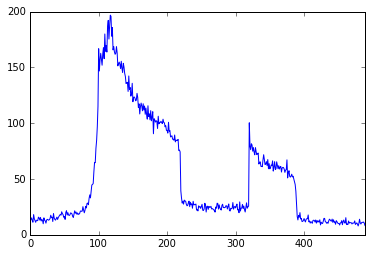

In [104]:
flat_profile.density.plot()